# A new way to normalization

## Optimal transport and Wasserstein distance
Let $\Omega \subset \mathbb{R}^d$ be a compact subset. Suppose $\mu, \nu \in \mathcal{M}_+(\Omega)$, with $\int d \mu = \int d \nu$. And $f$ and $g$ are the densities of $\mu$ and $\nu$ with respect to Lebesgue measure.
The optimal transport problem (in the sense of Kantorovich) is:
$$\min_{\gamma} \int_\Omega c(x,y) \ d \gamma(x,y), \quad \text{s.t. } \pi_\sharp^x \gamma = \mu,\ \pi_\sharp^y \gamma = \nu$$

When $c(x,y) = |x-y|^p$, the Wasserstein distance:
$$W_p^p(f, g) = \min_\gamma \int_\Omega |x-y|^p \ d \gamma(x,y)$$

As $p=2$, it can be shown that: the optimal transport problem exists an unique solution $\gamma$. And the 2-Wasserstein distance satisfies the symmetry property and triangle inequality.

## Normalization by adding a term
Since the mass equality condition $\int d\mu = \int d\nu$ is not satified in many cases, normalization will be needed.
Define:
$$\hat{W}_2^2(f,g) = W_2^2(\frac{f}{|f|}, \frac{g}{|g|})$$
Here $|f| = \int_\Omega f \ dx$. It can be shown the $\hat{W}_2^2$ is convex w.r.t $f$ with shift and dilate.

Also, we can define:
$$d(f,g) = \hat{W}_2^2(f,g) + \lambda ||f|-|g||.$$

So in this case, the new distance $d(f,g)$ is convex (not strictly) w.r.t shift, dilate and amplitude change.
Here $d(f,g)$ is not differentiable as $|f|=|g|$, we can still find a subgradient. (CHECK)

**Gradient**:

$$D_f d(f,g) = D_f W_2^2 (\frac{f}{|f|}, \frac{g}{|g|}) + \lambda D_f ||f|-|g||$$
For the first term:
$$D_f W_2^2 (\frac{f}{|f|}, \frac{g}{|g|}) = D_1 W_2^2 (\frac{f}{|f|}, \frac{g}{|g|}) \cdot D_f(\frac{f}{|f|}) \\
= D_1 W_2^2 (\frac{f}{|f|}, \frac{g}{|g|}) \cdot (-\frac{1}{|f|^2} f \mathbf{1}_N' + \frac{1}{|f|} \mathbf{I}_{N\times N})$$
For the second term, we can have a gradient (subgradient):
$$D_f ||f|-|g|| = \begin{cases}
\mathbf{1}_N', |f| > |g| \\
0, |f|=|g| \\
-\mathbf{1}_N', |f| < |g|
\end{cases}$$

## Signal
When we compare two signals $f$ and $g$, one way is to compare the corresponding positive and negative parts separately. Define projection operator maps the positive and negative parts of the signal:
$$P_{f+} f(x) = 
\begin{cases} f(x), f(x) \geq 0 \\ 0, f(x) < 0\end{cases}$$
$$P_{f-} f(x) = 
\begin{cases} 0, f(x) \geq 0 \\ f(x), f(x) < 0\end{cases}$$

In this case we have:
$$f(x) = P_{f+} f + P_{f-}f$$
and we can define a new distant between $f$ and $g$:
$$d_s(f,g) = \hat{W}_2^2 (P_{f+}f, P_{g+}g) + \hat{W}_2^2 (-P_{f-}f, -P_{g-}g) + \lambda ||P_{f+}f|-|P_{g+}g|| + \lambda ||-P_{f-}f|-|-P_{g-}g||$$

## Problem:

- Prove it is subgradient for $||f| - |g||$
- check for $d(f,g)$ is a distence, i.e. triangle inequality. Maybe not ok for the signal case.
- convexity w.r.t. time shift, dilation, amplitude change.
- insensitivity w.r.t. noise

In [1]:
using PyPlot
using PyCall
using LinearAlgebra

include("code/sinkhorn.jl")
ot = pyimport("ot")

function gauss_func(t, b, c)
    y = exp.(-(t.-b).^2 ./ (2*c^2));
    return y
end

function sin_func(t, omega, phi)
    return sin.(2*pi*omega*(t .- phi));
end

function ricker_func(t, t0, sigma)
    t = t.-t0;
    f = (1 .- t.^2 ./ sigma.^2) .* exp.(- t.^2 ./ (2 .* sigma.^2));
    return f
end

N = 101
x = range(0, stop=1, length=N)
M = cost_func_1d(N);

In [2]:
function sinkhorn_normalized_add(r, c, M; balance_coef=10, lambda=100, numItermax=1000, stopThr=1e-6, verbose=false)
    N = length(r)
    r1 = r ./ norm(r,1)
    c1 = c ./ norm(c,1)
    T, a, d = sinkhorn_basic(r1, c1, M; lambda=lambda, numItermax=numItermax, stopThr=stopThr, verbose=verbose)
    
    aaa = - (1 ./ sum(r)^2) * r * ones(N)' + 1 ./ sum(r) * I(N)
    grad1 = a' * aaa
    if sum(r) > sum(c)
        grad2 = balance_coef * ones(N)'
    elseif sum(r) < sum(c)
        grad2 = -balance_coef * ones(N)'
    else
        grad2 = 0 * ones(N)'
    end
    grad = grad1 + grad2
    
    dist = d + balance_coef*abs(sum(r)-sum(c))
    return T, grad, dist
end

sinkhorn_normalized_add (generic function with 1 method)

## Example of Gaussian

In [3]:
time_shift = 0.3:0.01:0.7
amp_shift = 0.5:0.01:1.5

n = length(time_shift)
m = length(amp_shift)
misfit = zeros(n,m)

c = gauss_func(x, 0.5, 0.05)

for i = 1:n
    for j = 1:m
        r = amp_shift[j] .* gauss_func(x, time_shift[i], 0.05)
        T, a, misfit[i,j] = sinkhorn_normalized_add(r, c, M; balance_coef=1e-2, lambda=1e-1, numItermax=10, stopThr=1e-6, verbose=false)
    end
end

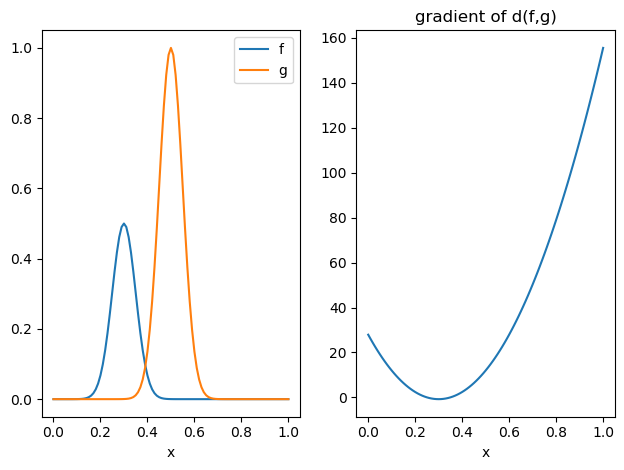

In [4]:
figure; subplot(121)
r = amp_shift[1] .* gauss_func(x, time_shift[1], 0.05)
T, a, dd = sinkhorn_normalized_add(r, c, M;balance_coef=1e-3, lambda=1e-1, numItermax=10, stopThr=1e-6, verbose=false)
plot(x,r,x,c)
legend(["f", "g"])
xlabel("x")

subplot(122); plot(x,a); xlabel("x"); title("gradient of d(f,g)")

tight_layout()

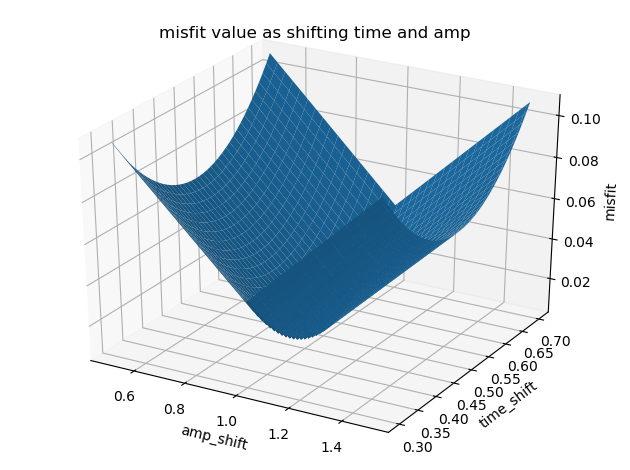

In [5]:
surf(amp_shift,time_shift,misfit)
xlabel("amp_shift")
ylabel("time_shift")
zlabel("misfit")
title("misfit value as shifting time and amp")
tight_layout()

## Signal

In [6]:
# that might be slow when N is large
function proj_p(f)
    N = length(f)
    Pp = zeros(N)
    p_ind = findall(x->x>=0, f)
    Pp[p_ind] .= 1
    Pp = diagm(Pp)
    
    return Pp
end

function proj_n(f)
    N = length(f)
    Pn = zeros(N)
    p_ind = findall(x->x<0, f)
    Pn[p_ind] .= 1
    Pn = diagm(Pn)
    
    return Pn
end

function sinkhorn_signal_1d_nor_add(r, c, M; balance_coef=10, lambda=100, numItermax=1000, stopThr=1e-6, verbose=false)
    N = length(r)
    Prp = proj_p(r)
    Prn = proj_n(r)
    Pcp = proj_p(c)
    Pcn = proj_n(c)

    rp = Prp * r
    rn = Prn * r
    cp = Pcp * c
    cn = Pcn * c
    
    rp1 = rp ./ norm(rp,1)
    cp1 = cp ./ norm(cp,1)
    Tp, ap, dp = sinkhorn_basic(rp1, cp1, M; lambda=1e3, numItermax=1000, stopThr=1e-6, verbose=false)
    aap = - (1 ./ sum(rp)^2) * r * ones(N)' + 1 ./ sum(rp) * I(N)
    gradp1 = ap' * aap * Prp

    if sum(rp) > sum(cp)
        gradp2 = balance_coef * ones(N)' * Prp
    elseif sum(r) < sum(c)
        gradp2 = -balance_coef * ones(N)' * Prp
    else
        gradp2 = 0 * ones(N)'
    end

    rn1 = rn ./ norm(rn,1)
    cn1 = cn ./ norm(cn,1)
    Tn, an, dn = sinkhorn_basic(-rn1, -cn1, M; lambda=1e3, numItermax=1000, stopThr=1e-6, verbose=false)
    aan = - (1 ./ sum(rn)^2) * r * ones(N)' + 1 ./ sum(rn) * I(N)
    gradn1 = an' * aan * (-Prn)

    if sum(-rn) > sum(-cn)
        gradn2 = balance_coef * ones(N)' * (-Prn)
    elseif sum(-rn) < sum(-cn)
        gradn2 = -balance_coef * ones(N)' * (-Prn)
    else
        gradn2 = 0 * ones(N)'
    end

    grad = gradp1 + gradp2 + gradn1 + gradn2
    dist = dp + dn + balance_coef*abs(sum(rp)-sum(cp)) + balance_coef*abs(sum(-rn)-sum(-cn))
    
    return Tp-Tn, grad, dist
end

sinkhorn_signal_1d_nor_add (generic function with 1 method)

In [8]:
time_shift = 0.3:0.01:0.7
amp_shift = 0.5:0.01:1.5

n = length(time_shift)
m = length(amp_shift)
misfit = zeros(n,m)

c = ricker_func(x, 0.5, 0.03)

for i = 1:n
    for j = 1:m
        r = amp_shift[j] .* ricker_func(x, time_shift[i], 0.03)
        T, a, misfit[i,j] = sinkhorn_signal_1d_nor_add(r, c, M; balance_coef=1e-2, lambda=1e3, numItermax=1000, stopThr=1e-6, verbose=false)
    end
end

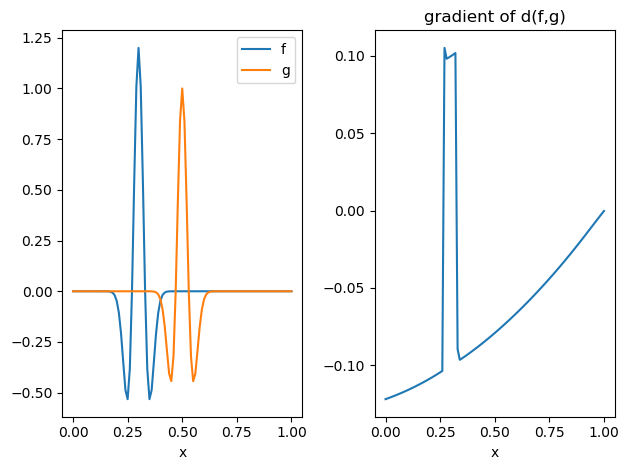

In [9]:
figure; subplot(121)
r = 1.2*ricker_func(x, 0.3, 0.03)
T, a, dd = sinkhorn_signal_1d_nor_add(r, c, M; balance_coef=1e-2, lambda=1e3, numItermax=1000, stopThr=1e-6, verbose=false)
plot(x,r,x,c)
legend(["f", "g"])
xlabel("x")

subplot(122); plot(x,a); xlabel("x"); title("gradient of d(f,g)")

tight_layout()

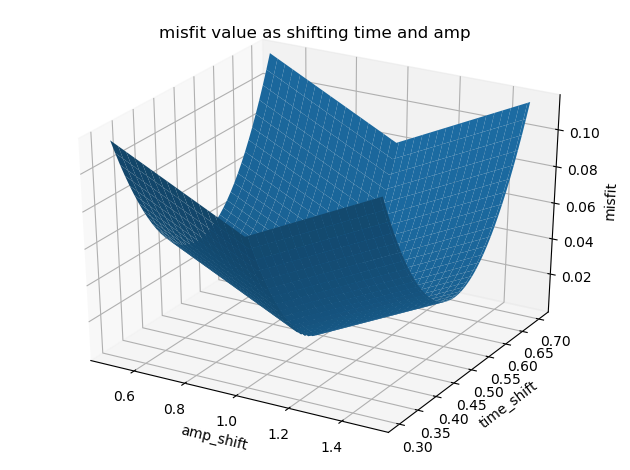

In [10]:
surf(amp_shift,time_shift,misfit)
xlabel("amp_shift")
ylabel("time_shift")
zlabel("misfit")
title("misfit value as shifting time and amp")
tight_layout()

In [11]:
# # code backup
# Prp = proj_p(r)
# Prn = proj_n(r)
# Pcp = proj_p(c)
# Pcn = proj_n(c)

# rp = Prp * r
# rn = Prn * r
# cp = Pcp * c
# cn = Pcn * c

# # plot(x,rp,x,rn,x,cp,x,cn)

# rp1 = rp ./ norm(rp,1)
# cp1 = cp ./ norm(cp,1)
# Tp, ap, dp = sinkhorn_basic(rp1, cp1, M; lambda=1e3, numItermax=1000, stopThr=1e-6, verbose=false)
# aap = - (1 ./ sum(rp)^2) * r * ones(N)' + 1 ./ sum(rp) * I(N)
# gradp1 = ap' * aap * Prp

# if sum(rp) > sum(cp)
#     gradp2 = balance_coef * ones(N)' * Prp
# elseif sum(r) < sum(c)
#     gradp2 = -balance_coef * ones(N)' * Prp
# else
#     gradp2 = 0 * ones(N)'
# end

# rn1 = rn ./ norm(rn,1)
# cn1 = cn ./ norm(cn,1)
# Tn, an, dn = sinkhorn_basic(-rn1, -cn1, M; lambda=1e3, numItermax=1000, stopThr=1e-6, verbose=false)
# aan = - (1 ./ sum(rn)^2) * r * ones(N)' + 1 ./ sum(rn) * I(N)
# gradn1 = an' * aan * (-Prn)

# if sum(-rn) > sum(-cn)
#     gradn2 = balance_coef * ones(N)' * (-Prn)
# elseif sum(-rn) < sum(-cn)
#     gradn2 = -balance_coef * ones(N)' * (-Prn)
# else
#     gradn2 = 0 * ones(N)'
# end

# grad = gradp1 + gradp2 + gradn1 + gradn2

# figure; subplot(121); imshow(Tp)
# subplot(122); imshow(Tn); tight_layout()

# # plot(gradp1 + gradn1)
# plot(grad * 10)
# plot(c-r)
# # plot(gradn1)
# # plot(gradp2)
# # plot(gradn2)